[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  K-Means super pixcel

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 12/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0058ClusteringKMeans.ipynb)

In [15]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Image Processing Computer Vision
import skimage as ski

# Machine Learning
from kneed import KneeLocator #<! Elbow Method
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import MinMaxScaler

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [16]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [17]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [18]:
# Courses Packages


In [19]:
# General Auxiliary Functions

def ConvertRgbToLab( mRgb: np.ndarray ) -> np.ndarray:
    # Converts sets of RGB features into LAB features.
    # Input (numPx x 3)
    # Output: (numPx x 3)
    mRgb3D = np.reshape(mRgb, (1, -1, 3))
    mLab3D = ski.color.rgb2lab(mRgb3D)

    return np.reshape(mLab3D, (-1, 3))
    

def PlotSuperPixels( mI: np.ndarray, mMask: np.ndarray, boundColor: Tuple[float, float, float] = (0.0, 1.0, 1.0), figSize: Tuple[int, int] = FIG_SIZE_DEF, hA: Optional[plt.Axes] = None ) -> plt.Axes:

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()
    
    mO = ski.segmentation.mark_boundaries(mI, mMask, boundColor)
    
    hA.imshow(mO)

    return hA

def PlotFeaturesHist( mX: np.ndarray, figSize: Tuple[int, int] = FIG_SIZE_DEF, hF: Optional[plt.Figure] = None ) -> plt.Figure:

    numFeatures = mX.shape[1]
    
    if hF is None:
        hF, hA = plt.subplots(nrows = 1, ncols = numFeatures, figsize = figSize)
    else:
        hA = np.array(hF.axes)
    
    hA = hA.flat

    if len(hA) != numFeatures:
        raise ValueError(f'The number of axes in the figure: {len(hA)} does not match the number of features: {numFeatures} in the data')
    
    for ii in range(numFeatures):
        hA[ii].hist(mX[:, ii])
    
    return hF


## Clustering by K-Means

In this notebook we'll do the following things:

1. Implement K-Means manually.
2. Use the K-Means to extract Super Pixels (A model for image segmentation).

The Super Pixel is a simple clustering method which says s Super Pixel is a cluster f pixels which are localized and have similar colors.  
Hence it fits to be applied using a clustering method with the features being the values of the pixels and its coordinates.

The steps are as following:

1. Load the `Fruits.jpeg` image and covert it to NumPy array `mI` using the [SciKit Image](https://github.com/scikit-image/scikit-image) library.  
   See [`imread()`](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread).
2. The image is given by $ I \in \mathbb{R}^{m \times n \times c}$ where $ c =  $ is the number of channels (`RGB`).   
   We need to convert it into $ X \in \mathbb{R}^{mn \times 3}$.  
   Namely, a 2D array where each row is the RGB values triplets.
3. Feature Engineering:  
   - Convert data into a color space with approximately euclidean metric -> [LAB Color Space](https://en.wikipedia.org/wiki/CIELAB_color_space).
   - Add the Row / Column indices of each pixel as one the features.
   - Scale features to have the same range.
4. Apply K-Means clustering on the features.
5. Use the label of each pixel (The cluster it belongs to) to segment the image (Create Super Pixels).
6. Plot the segmentation (Super Pixels) map.

* <font color='brown'>(**#**)</font> You may try different color spaces.
* <font color='brown'>(**#**)</font> You may try different scaling of the features.



![](https://i.imgur.com/1HAq02c.png)

In [20]:
# Parameters

# Data
imgUrl = r'https://github.com/FixelAlgorithmsTeam/FixelCourses/raw/master/MachineLearningMethod/16_ParametricClustering/Fruits.jpeg'

# Model
numClusters = 50
numIter     = 500



## Generate / Load Data

Load the fruits image.


In [21]:
# Load Data

mI = ski.io.imread(imgUrl)


print(f'The image shape: {mI.shape}')

The image shape: (375, 500, 3)


### Plot Data

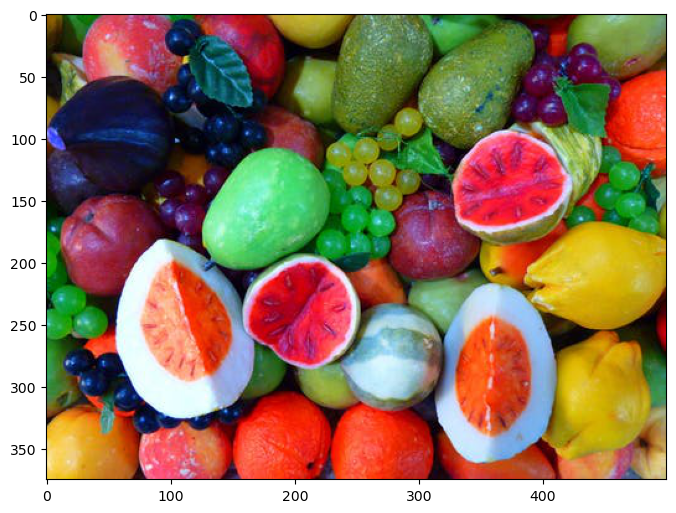

In [22]:
# Plot the Data

hF, hA = plt.subplots(figsize = (8, 8))

# Display the image
hA.imshow(mI)

plt.show()


## Pre Processing

We need to convert the image from `(numRows, numCols, numChannels)` to `(numRows * numCols, numChannels)`.  
In our case, `numChannels = 3` as we work with `RGB` image.

In [23]:
# Convert Image into Features Matrix

numRows, numCols, numChannel = mI.shape

#===========================Fill This===========================#
mX = np.reshape(mI, (numRows * numCols, numChannel))
#===============================================================#

print(f'The features data shape: {mX.shape}')

The features data shape: (187500, 3)


## Feature Engineering

In this section we'll apply the feature engineering:

1. Convert data into a meaningful color space (LAB).
2. Add the location (Row / Column indices) information as a feature to segment the image.
3. Scale features to have similar dynamic range.

In [24]:
# Convert Features into LAB Color Space
mX = ConvertRgbToLab(mX) #<! Have a look on the function

In [25]:
# Add the Indices as Features

#===========================Fill This===========================#
# 1. Create a vector of the row index of each pixel.
# 2. Create a vector of the column index of each pixel.
# 3. Stack them as additional columns to `mX`.
# !! Python is column major.
# !! The number of elements in the vectors should match the number of pixels.
# !! You may find `repeat()` and `tile()` functions (NumPy) useful.
vR = np.repeat(np.arange(numRows), repeats = numCols) #<! Row indices
vC = np.tile(np.arange(numCols), reps = numRows) #<! Column indices
mX = np.column_stack((mX, vR, vC))
#===============================================================#

numFeat = mX.shape[1]

print(f'The features data shape: {mX.shape}')

The features data shape: (187500, 5)


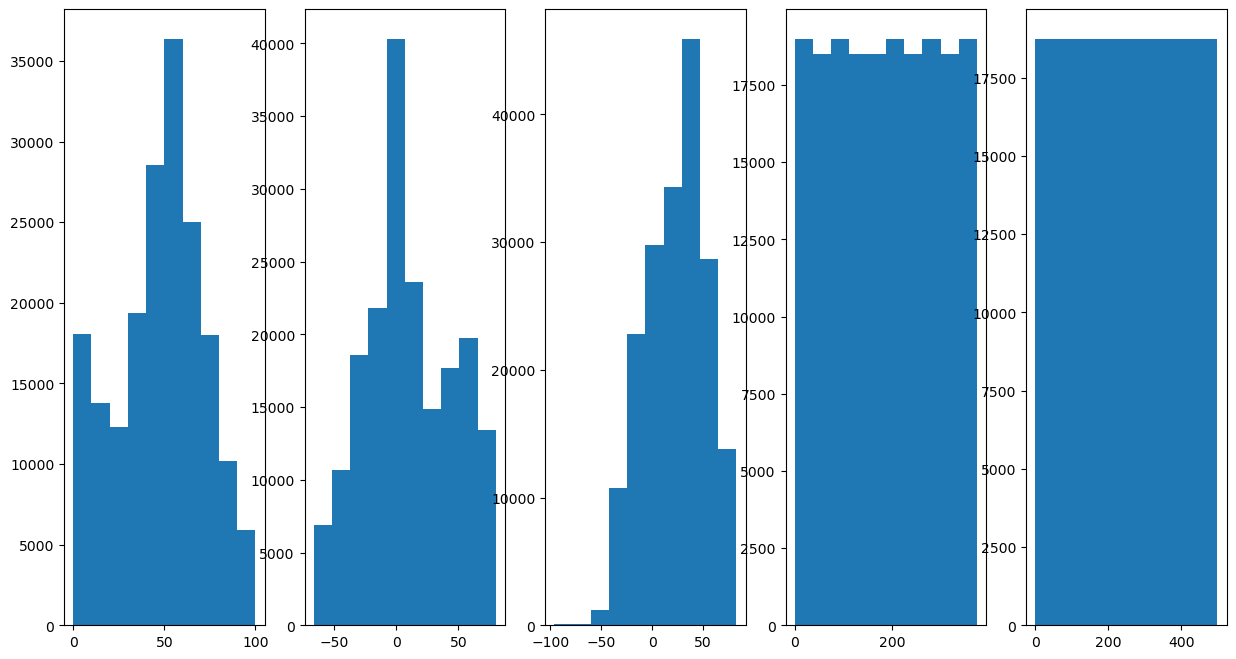

In [26]:
# Plot the Features Histogram 
hF, hA = plt.subplots(nrows = 1, ncols = numFeat, figsize = (15, 8))
hF = PlotFeaturesHist(mX, hF = hF)

In [27]:
# Scale Features
# Scale each feature into the [0, 1] range.
# Having similar scaling means have similar contribution when calculating the distance.

#===========================Fill This===========================#
# 1. Construct the `MinMaxScaler` object.
# 2. Use it to transform the data.
oMinMaxScaler = MinMaxScaler()
mX = oMinMaxScaler.fit_transform(mX)
#===============================================================#

* <font color='red'>(**?**)</font> What would happen if we didn't scale the row and columns indices features?

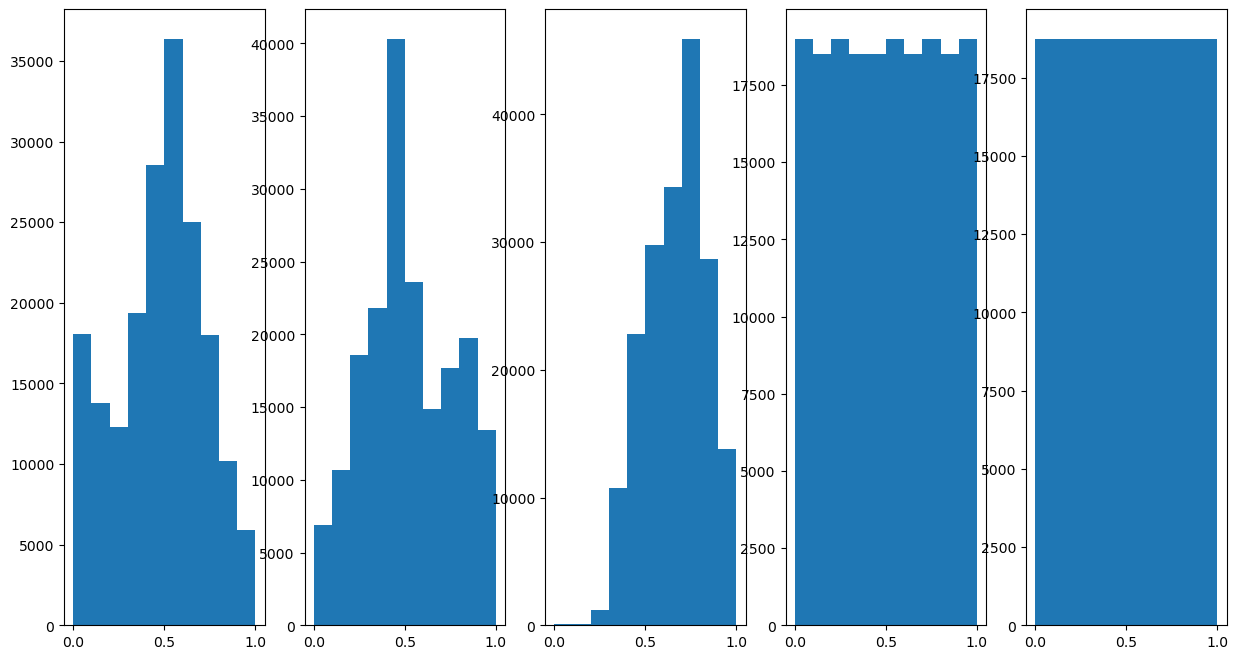

In [28]:
# Plot the Features Histogram 
hF, hA = plt.subplots(nrows = 1, ncols = numFeat, figsize = (15, 8))
hF = PlotFeaturesHist(mX, hF = hF)

## Cluster Data by K-Means

1. Step I:  
Assume fixed centroids $\left\{ \boldsymbol{\mu}_{k}\right\} $, find the optimal clusters $\left\{ \mathcal{D}_{k}\right\} $:  
$$\arg\min_{\left\{ \mathcal{D}_{k}\right\} }\sum_{k = 1}^{K}\sum_{\boldsymbol{x}_{i}\in\mathcal{D}_{k}}\left\Vert \boldsymbol{x}_{i}-\boldsymbol{\mu}_{k}\right\Vert _{2}^{2}$$
$$\implies \boldsymbol{x}_{i}\in\mathcal{D}_{s\left(\boldsymbol{x}_{i}\right)} \; \text{where} \; s\left(\boldsymbol{x}_{i}\right)=\arg\min_{k}\left\Vert \boldsymbol{x}_{i}-\boldsymbol{\mu}_{k}\right\Vert _{2}^{2}$$

2. Step II:  
Assume fixed clusters $\left\{ \mathcal{D}_{k}\right\} $, find the optimal centroids $\left\{ \boldsymbol{\mu}_{k}\right\} $:
$$\arg\min_{\left\{ \boldsymbol{\mu}_{k}\right\} }\sum_{k=1}^{K}\sum_{\boldsymbol{x}_{i}\in\mathcal{D}_{k}}\left\Vert \boldsymbol{x}_{i}-\boldsymbol{\mu}_{k}\right\Vert _{2}^{2}$$
$$\implies\boldsymbol{\mu}_{k}=\frac{1}{\left|\mathcal{D}_{k}\right|}\sum_{\boldsymbol{x}_{i}\in\mathcal{D}_{k}}\boldsymbol{x}_{i}$$

3. Step III:  
Check for convergence (Change in assignments / location of the center). If not, go to _Step I_.

* <font color='brown'>(**#**)</font> The K-Means is implemented in [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
* <font color='brown'>(**#**)</font> Some implementations of the algorithm supports different metrics.


* <font color='red'>(**?**)</font> With regard to the `RGB` features, is the metric used is the `Squared Euclidean`?

### The K-Means Algorithm

Implement the K-Means algorithm as a SciKit Learn compatible class.

* <font color='brown'>(**#**)</font> The implementation will allow different metrics.


In [29]:
# Implement the K-Means as an Estimator

class KMeansCluster(ClusterMixin, BaseEstimator):
    def __init__(self, numClusters: int, numIter: int = 1000, metricType: str = 'sqeuclidean'):
        #===========================Fill This===========================#
        # 1. Add `numClusters` as an attribute of the object.
        # 2. Add `numIter` as an attribute of the object.
        # 3. Add `metricType` as an attribute of the object.
        # !! The `metricType` must match the values of SciPy's `cdist()`: 'euclidean', 'cityblock', 'seuclidean', 'sqeuclidean', 'cosine', 'correlation'.
        self.numClusters = numClusters
        self.numIter     = numIter
        self.metricType  = metricType
        #===============================================================#

        pass
    
    def fit(self, mX: np.ndarray, vY: Optional[np.ndarray] = None) -> Self:

        numSamples  = mX.shape[0]
        featuresDim = mX.shape[1]

        if (numSamples < self.numClusters):
            raise ValueError(f'The number of samples: {numSamples} should not be smaller than the number of clusters: {self.numClusters}.')

        mC = mX[np.random.choice(numSamples, self.numClusters, replace = False)] #<! Centroids (Random initialization)
        vL = np.zeros(numSamples, dtype = np.int64) #<! Labels
        vF = np.zeros(numSamples, dtype = np.bool_) #<! Flags for each label
        
        #===========================Fill This===========================#
        # 1. Create a loop of the number of samples.
        # 2. Create the distance matrix between each sample to the centroids (Use the appropriate metrics).
        # 3. Extract the labels.
        # 4. Iterate on each label group to update the centroids.
        # !! You may find `cdist()` from SciPy useful.
        # !! Use `mean()` to calculate the centroids.
        for ii in range(self.numIter):
            mD = sp.spatial.distance.cdist(mX, mC, self.metricType) #<! Distance Matrix (numSamples, numClusters)
            vL = np.argmin(mD, axis = 1, out = vL)
            for kk in range(numClusters):
                # Update `mC`
                vF = np.equal(vL, kk, out = vF)
                if np.any(vF):
                    mC[kk, :] = np.mean(mX[vL == kk, :], axis = 0)
        #===============================================================#

        # SciKit Learn's `KMeans` compatibility
        self.cluster_centers_   = mC
        self.labels_            = vL
        self.inertia_           = np.sum(np.amin(mD, axis = 1))
        self.n_iter_            = self.numIter
        self.n_features_in      = featuresDim

        return self
    
    def transform(self, mX):

        return sp.spatial.distance.cdist(mX, self.cluster_centers_, self.metricType)
    
    def predict(self, mX):

        vL = np.argmin(self.transform(mX), axis = 1)

        return vL
    
    def score(self, mX: np.ndarray, vY: Optional[np.ndarray] = None):
        # Return the opposite of inertia as the score

        mD = self.transform(mX)
        inertiaVal = np.sum(np.amin(mD, axis = 1))

        return -inertiaVal


* <font color='red'>(**?**)</font> Why do the `fit()` and `predict()` method have the `vY` input?
* <font color='red'>(**?**)</font> If one selects `'cosine'` as the distance metric, does the centroid match the metric?
* <font color='green'>(**@**)</font> Add an option for `K-Means++` initialization.
* <font color='red'>(**?**)</font> How can one use K-Means in an online fashion? Think of a static and dynamic case.
* <font color='red'>(**?**)</font> Is the above implementation static or dynamic?
* <font color='green'>(**@**)</font> Add a stopping criteria: The maximum movement of a centroid is below a threshold.

### Super Pixel Clustering by K-Means

In [30]:
# Construct the Model & Fit to Data

#===========================Fill This===========================#
# 1. Construct the `KMeansCluster` object.
# 2. Fit it to data.
oKMeans = KMeansCluster(numClusters = numClusters, numIter = numIter)
oKMeans = oKMeans.fit(mX)
#===============================================================#


* <font color='red'>(**?**)</font> What's the difference between `fit()` and `predict()` in the context of K-Means?

In [31]:
# Extract the Labels and Form a Segmentation Mask

#===========================Fill This===========================#
# 1. Extract the labels of the pixels (Cluster index).
# 2. Reshape them into a mask which matches the image.
mSuperPixel = np.reshape(oKMeans.labels_, (numRows, numCols))
#===============================================================#

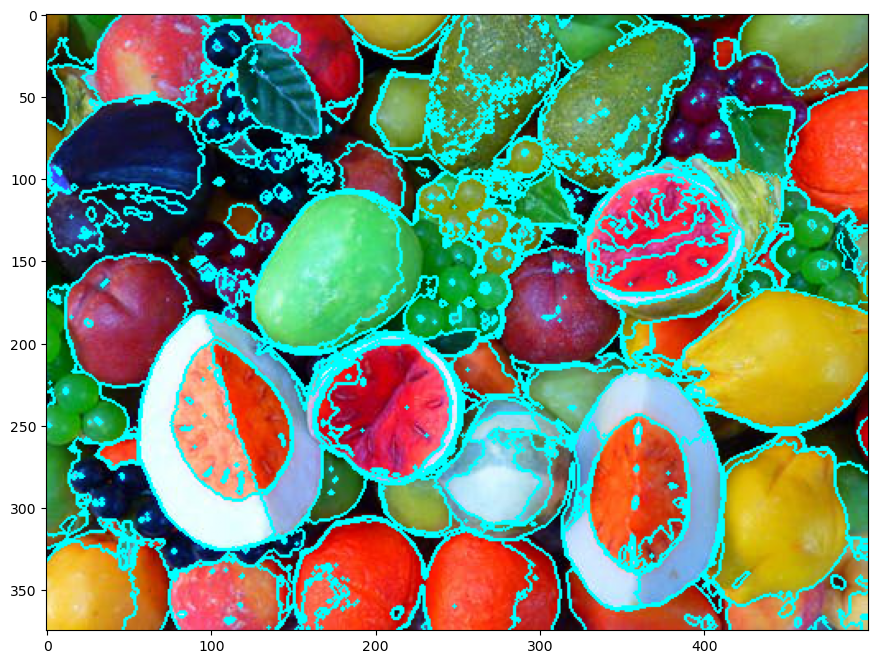

In [32]:
# Display Results

hF, hA = plt.subplots(figsize = (12, 8))
PlotSuperPixels(mI, mSuperPixel, hA = hA)

plt.show()

* <font color='red'>(**?**)</font> How do we set the hyper parameter `K` for `K-Means`?
* <font color='red'>(**?**)</font> Why are the separating lines not straight?
* <font color='green'>(**@**)</font> Run the notebook again yet using SciKit Learn `KMeans` class. Compare speed.

### Analysis of Hyper Parameter `K`

One common method to find the optimal `K` is the [Knee / Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).    
In this method a score (Inertia) is plotted vs. the `K` parameter.  
One way to define the _elbow point_ is by the point maximizing the [curvature](https://en.wikipedia.org/wiki/Curvature).  
This point can be easily calculated by the [`kneed`](https://github.com/arvkevi/kneed) package.

* <font color='brown'>(**#**)</font> An alternative to the _elbow method_ is using [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)). See [Stop Using the Elbow Method](https://scribe.rip/96bcfbbbe9fd), [Selecting the Number of Clusters with Silhouette Analysis on KMeans Clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).
* <font color='brown'>(**#**)</font> [Method to Analyze K in K-Means](https://datascience.stackexchange.com/questions/6508).

In [33]:
# Score per K
# Takes 4-6 minutes!
lK = [10, 25, 50, 100, 150, 200, 500]
numK = len(lK)
vS = np.full(shape = numK, fill_value = np.nan)

for ii, kVal in enumerate(lK):
    oKMeans = KMeansCluster(numClusters = kVal, numIter = numIter)
    oKMeans = oKMeans.fit(mX)
    vS[ii]  = oKMeans.score(mX)
    print(f'Finished processing the {ii} / {numK} iteration with K = {kVal}')

Finished processing the 0 / 7 iteration with K = 10
Finished processing the 1 / 7 iteration with K = 25
Finished processing the 2 / 7 iteration with K = 50
Finished processing the 3 / 7 iteration with K = 100
Finished processing the 4 / 7 iteration with K = 150
Finished processing the 5 / 7 iteration with K = 200
Finished processing the 6 / 7 iteration with K = 500


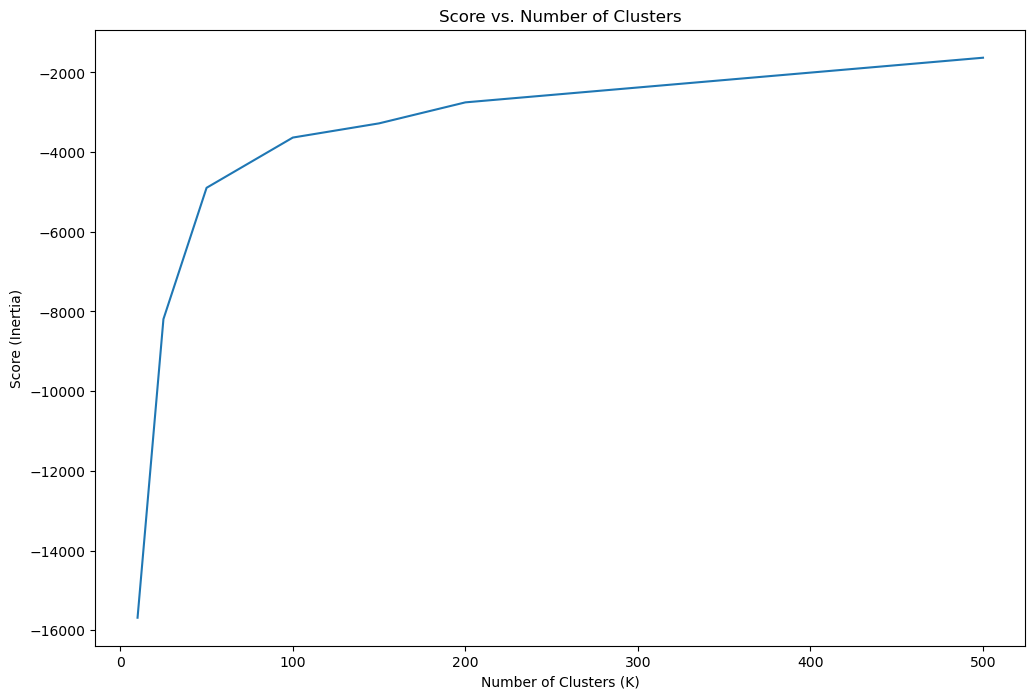

In [34]:
# Plot the Score
hF, hA = plt.subplots(figsize = (12, 8))
hA.plot(lK, vS, label = 'Score')
hA.set_xlabel('Number of Clusters (K)')
hA.set_ylabel('Score (Inertia)')
hA.set_title('Score vs. Number of Clusters')

plt.show()

In [35]:
# Locate the Knee Point by Maximum Curvature

oKneeLoc    = KneeLocator(lK, vS, curve = 'concave', direction = 'increasing')
kneeK       = round(oKneeLoc.knee)
kneeIdx     = lK.index(kneeK)

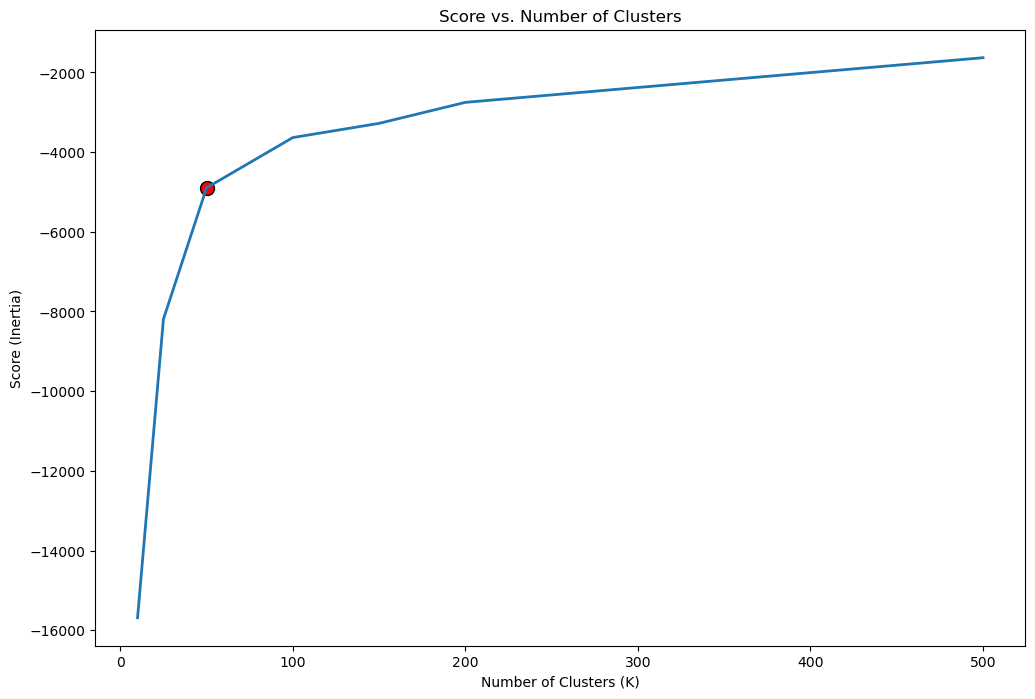

In [36]:
# Plot the Knee
hF, hA = plt.subplots(figsize = (12, 8))
hA.plot(lK, vS, lw = 2, label = 'Score')
hA.scatter(lK[kneeIdx], vS[kneeIdx], s = 100, c = 'r', edgecolors = 'k', label = 'Knee')
hA.set_xlabel('Number of Clusters (K)')
hA.set_ylabel('Score (Inertia)')
hA.set_title('Score vs. Number of Clusters')

plt.show()